<a href="https://colab.research.google.com/github/emilyhasson/gsod-analysis/blob/main/code/gsod_fog_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title  <-- Run Me: (Hidden) Installing Spark
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get -qq install -y openjdk-8-jdk-headless

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Setting up openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/servertool to provide /usr/bin/servertool (servertool) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/tnameserv to provide /usr/bin/tnameserv (tnameserv) in auto mode
Setting up ope

In [2]:
#@title  <-- Run Me: (Hidden) Environment Variable Setup
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

# Load Data from GitHub

In [4]:
!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2000_dir/2000weatherdata.csv"
df_2000 = spark.read.csv('2000weatherdata.csv', inferSchema = True, header = True)
dfs = []
dfs.append(df_2000)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2001_dir/2001weatherdata.csv"
df_2001 = spark.read.csv('2001weatherdata.csv', inferSchema = True, header = True)
dfs.append(df_2001)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2002_dir/2002weatherdata.csv"
df_2002 = spark.read.csv('2002weatherdata.csv', inferSchema = True, header = True)
dfs.append(df_2002)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2003_dir/2003weatherdata.csv"
df = spark.read.csv('2003weatherdata.csv', inferSchema = True, header = True)
dfs.append(df)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2004_dir/2004weatherdata.csv"
df = spark.read.csv('2004weatherdata.csv', inferSchema = True, header = True)
dfs.append(df)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2005_dir/2005weatherdata.csv"
df = spark.read.csv('2005weatherdata.csv', inferSchema = True, header = True)
dfs.append(df)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2006_dir/2006weatherdata.csv"
df = spark.read.csv('2006weatherdata.csv', inferSchema = True, header = True)
dfs.append(df)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2007_dir/2007weatherdata.csv"
df = spark.read.csv('2007weatherdata.csv', inferSchema = True, header = True)
dfs.append(df)

!wget "https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2008_dir/2008weatherdata.csv"
df = spark.read.csv('2008weatherdata.csv', inferSchema = True, header = True)
dfs.append(df)

--2022-05-10 00:06:44--  https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2000_dir/2000weatherdata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11045114 (11M) [text/plain]
Saving to: ‘2000weatherdata.csv’

2000weatherdata.csv 100%[===================>]  10.53M  --.-KB/s    in 0.08s   

2022-05-10 00:06:44 (137 MB/s) - ‘2000weatherdata.csv’ saved [11045114/11045114]

--2022-05-10 00:06:54--  https://raw.githubusercontent.com/emilyhasson/gsod-analysis/main/data/2001_dir/2001weatherdata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

Union all yearly dataframes

In [7]:
import functools
def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

udf = unionAll(dfs)

# Model Construction

Combine all predictor variables into a vectorized features column

In [11]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
assembler = VectorAssembler(inputCols=["station_num", "year", "month", "day", "temp_ft", 
                                            "dewpt_ft", "slp_mb", "visib_mi", "wind_knt", "maxwind_knt", 
                                            "GUST", "rain", "snow", "hail", "thunder", "tornado", "max_temp_frnht",  
                                            "min_temp_frnht", "precip_in"],
                            outputCol="features")
assembler_df=assembler.transform(udf.fillna(0))
assembler_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- temp_ft: double (nullable = false)
 |-- dewpt_ft: double (nullable = false)
 |-- slp_mb: double (nullable = false)
 |-- visib_mi: double (nullable = false)
 |-- wind_knt: double (nullable = false)
 |-- maxwind_knt: double (nullable = false)
 |-- GUST: double (nullable = false)
 |-- fog: integer (nullable = true)
 |-- rain: integer (nullable = true)
 |-- snow: integer (nullable = true)
 |-- hail: integer (nullable = true)
 |-- thunder: integer (nullable = true)
 |-- tornado: integer (nullable = true)
 |-- max_temp_frnht: double (nullable = false)
 |-- min_temp_frnht: double (nullable = false)
 |-- precip_in: double (nullable = false)
 |-- precip_flag: string (nullable = true)
 |-- SNDP: double (nullable = false)
 |-- STP: double (nullable = false)
 |-- WBAN: integer (nullable = true)
 |-- 

Next, split the data into training and testing sets (80% and 20%, respectively)

In [12]:
train, test = assembler_df.randomSplit([0.8, 0.2], seed=666)
print("Train count: " + str(train.count()))
print("Test count: " + str(test.count()))
train.groupby("Fog").count().show() # checking that distribution of response is reasonably evenly split

Train count: 946943
Test count: 236195
+---+------+
|Fog| count|
+---+------+
|  1|417128|
|  0|529815|
+---+------+



Train the model

In [13]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol='fog', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test).withColumnRenamed("fog", "label")
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,1,"(38800.0, 2000.0, 1.0, 1.0, 48.3, 47.7, 1025.2...","[0.4731902129507075, -0.4731902129507075]",0.0,"[0.6161385585300159, 0.38386144146998413]"
1,0,"(64324.0, 2000.0, 1.0, 2.0, 0.0, 0.0, 0.0, 4.3...","[-0.2978054467200346, 0.2978054467200346]",1.0,"[0.42609404742019547, 0.5739059525798045]"
2,1,"[64560.0, 2000.0, 1.0, 1.0, 40.8, 40.6, 1025.6...","[-4.929418155464096, 4.929418155464096]",1.0,"[0.007178801381066684, 0.9928211986189334]"
3,0,"(71400.0, 2000.0, 1.0, 1.0, 46.2, 45.6, 1027.2...","[0.5935287119442654, -0.5935287119442654]",0.0,"[0.6441743858404683, 0.35582561415953173]"
4,1,"(72070.0, 2000.0, 1.0, 1.0, 51.4, 0.0, 1027.8,...","[0.39315701537826797, -0.39315701537826797]",0.0,"[0.5970424549071369, 0.4029575450928631]"


# Model evaluation

Evaluate model using ROC

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator()
print("Area under ROC: ", eval.evaluate(predictions))

Area under ROC:  0.7736072809230597


Evaluate model accuracy

In [15]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.726442134676856


Confusion matrix

In [18]:
class_names=[1.0,0.0]
import itertools
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.46482011 0.53517989]
 [0.0656363  0.9343637 ]]


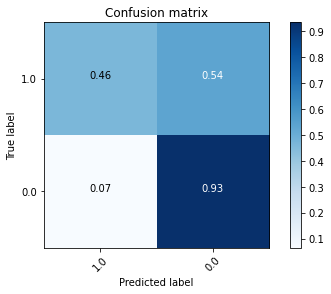

In [20]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix')
plt.show()